In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

# symbols = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "AMZN"]



def get_data(symbol,start_date,end_date):
        # Fetch historical data
    filename = f"{symbol}_{start_date}_to_{end_date}.csv"
    if os.path.exists(filename):
        print("CSV exists, skipping download:", filename)
    else:
        data = yf.download(symbol, start=start_date, end=end_date)
        data.to_csv(filename)
        print("Saved CSV:", filename)
    return pd.read_csv(filename, index_col=0, parse_dates=True)

        
symbol = "AAPL"
start_date = "2015-10-26"  
end_date = "2025-10-26"

# load CSV back into `data`
data = get_data(symbol,start_date,end_date)
print("Loaded CSV rows:", len(data))


# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()


CSV exists, skipping download: AAPL_2015-10-26_to_2025-10-26.csv
Loaded CSV rows: 2517


C:\Users\Lau\AppData\Local\Temp\ipykernel_14860\2584634521.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
0,2015-10-26,25.90636444091797,26.546831997375826,25.825463095415913,26.535596747151715,265335200
1,2015-10-27,25.7423152923584,26.189518706374272,25.616467804532167,25.93333168813241,279537600
2,2015-10-28,26.803016662597656,26.809759869563173,26.0816478240831,26.27715967760422,342205600
3,2015-10-29,27.0861759185791,27.122132837050888,26.578295589546713,26.67492766478933,204909200
4,2015-10-30,26.854700088500977,27.241228263679538,26.843463126505448,27.189540638827655,197461200


In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.W_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.W_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.W_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.W_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.U_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f + self.b_f)
            g_t = torch.tanh(x_t @ self.W_c + h_t @ self.U_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [3]:
# ...existing code...
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Parameters (tune as needed)
SEQ_LEN = 60        # number of past days used to predict
FORCAST = 14        # predict 20 days ahead (target is the value forcast steps after the input window)
BATCH_SIZE = 64
TRAIN_RATIO = 0.8
FEATURES = ["Close", "Volume"]
# 1) prepare series (use Close price)
series = data[FEATURES].dropna().values.astype(np.float32)
n_total = len(series)
if n_total < SEQ_LEN + FORCAST:
    raise ValueError("Not enough data for the chosen SEQ_LEN/forcast")

def get_denom(n_total, series):
    # 2) train / test split indices for scaling (avoid leakage)
    train_end = int(n_total * TRAIN_RATIO)
    train_series = series[:train_end]
    # MinMax scaler using train set
    train_min = train_series.min(axis=0)
    train_max = train_series.max(axis=0)
    scale_denom = (train_max - train_min)
    scale_denom[scale_denom == 0] = 1.0  # avoid div by zero
    
    return train_min, train_max,scale_denom

def scale(x, train_min, scale_denom):
    return (x - train_min) / scale_denom

train_min, train_max, scale_denom = get_denom(n_total, series)
series_scaled = scale(series, train_min, scale_denom)
print("Series scaled shape:", series_scaled.shape)  # (n_total, 1)
# 3) create sequences and targets
def create_sequences(data_arr, seq_len, forcast):
    xs, ys = [], []
    for i in range(0, len(data_arr) - seq_len - (forcast - 1)):
        x = data_arr[i : i + seq_len]
        y = data_arr[i + seq_len + (forcast - 1)]
        xs.append(x)
        ys.append(y)
    return np.stack(xs), np.stack(ys)

X_all, y_all = create_sequences(series_scaled, SEQ_LEN, FORCAST)
y_all = y_all[:, 0:1]
print("X_all shape:", X_all.shape)  # (N, SEQ_LEN, 1)
print("y_all shape:", y_all.shape)  # (N, 1)
# 4) split sequences into train / test by sequence count
n_seq = len(X_all)
train_seq_count = int(n_seq * TRAIN_RATIO)

X_train, y_train = X_all[:train_seq_count], y_all[:train_seq_count]
X_test,  y_test  = X_all[train_seq_count:], y_all[train_seq_count:]

# 5) Dataset wrapper
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()       # shape: (N, seq_len, 1)
        self.y = torch.from_numpy(y).float()       # shape: (N, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SequenceDataset(X_train, y_train)
test_dataset  = SequenceDataset(X_test,  y_test)

# 6) DataLoaders (assign train_loader as requested)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader   = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


# 7) quick sanity print
print(f"Total series length: {n_total}, sequences: {n_seq}")
print(f"Train sequences: {len(train_dataset)}, Test sequences: {len(test_dataset)}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
# ...existing code...


Series scaled shape: (2515, 2)
X_all shape: (2442, 60, 2)
y_all shape: (2442, 1)
Total series length: 2515, sequences: 2442
Train sequences: 1953, Test sequences: 489
X_train shape: (1953, 60, 2), y_train shape: (1953, 1)


In [4]:
import platform


# device selection: prefer CUDA only when running on Windows and CUDA is available
device = torch.device("cuda" if (platform.system() == "Windows" and torch.cuda.is_available()) else "cpu")
print("Platform:", platform.system(), "CUDA available:", torch.cuda.is_available(), "Using device:", device)


Platform: Windows CUDA available: True Using device: cuda


In [5]:
# training hyperparams

# hidden state size used by NaiveCustomLSTM 
ISTRAIN = True
HIDDEN_SIZE = 64  
# LR = 1e-3  
LR = 0.05
EPOCHS = 50
FEATURE_SIZE = len(FEATURES)  # should be 1 for univariate series
# model + simple linear head that maps last hidden state -> scalar prediction
model = NaiveCustomLSTM(input_sz=FEATURE_SIZE, hidden_sz=HIDDEN_SIZE).to(device)
# head = nn.Linear(HIDDEN_SIZE, 1).to(device)
head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(HIDDEN_SIZE, 1)
).to(device)

criterion = nn.MSELoss()
# criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(head.parameters()), lr=LR)

In [6]:


def start_train():
    for epoch in range(1, EPOCHS + 1):
        model.train()
        head.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)          # shape: (B, seq_len, 1)
            yb = yb.to(device)          # shape: (B, 1)
            optimizer.zero_grad()
            out_seq, _ = model(xb)      # out_seq: (B, seq_len, hidden)
            last_h = out_seq[:, -1, :]  # take last time-step hidden (B, hidden)
            preds = head(last_h)        # (B, 1)
            # compute loss between model predictions and targets (e.g., MSE)
            loss = criterion(preds, yb)
            # backpropagate gradients through model and head parameters
            loss.backward()
            # apply optimizer step to update parameters (Adam)
            optimizer.step() 
            running_loss += loss.item() * xb.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # validation / test eval
        model.eval()
        head.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                out_seq, _ = model(xb)
                preds = head(out_seq[:, -1, :])
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss = val_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else float("nan")

        print(f"Epoch {epoch}/{EPOCHS} — train_loss: {train_loss:.6f}  val_loss: {val_loss:.6f}")
        
        # export model
        torch.save({
            'model_state_dict': model.state_dict(),
            'head_state_dict': head.state_dict(),
        }, 'lstm_price_model_multi.pth')

if ISTRAIN :
    start_train()


Epoch 1/50 — train_loss: 0.510178  val_loss: 0.741489
Epoch 2/50 — train_loss: 0.096072  val_loss: 0.357200
Epoch 3/50 — train_loss: 0.032793  val_loss: 0.111419
Epoch 4/50 — train_loss: 0.017500  val_loss: 0.092294
Epoch 5/50 — train_loss: 0.012516  val_loss: 0.074489
Epoch 6/50 — train_loss: 0.010248  val_loss: 0.071582
Epoch 7/50 — train_loss: 0.009691  val_loss: 0.062452
Epoch 8/50 — train_loss: 0.009354  val_loss: 0.044565
Epoch 9/50 — train_loss: 0.008079  val_loss: 0.051319
Epoch 10/50 — train_loss: 0.007496  val_loss: 0.057384
Epoch 11/50 — train_loss: 0.007048  val_loss: 0.055477
Epoch 12/50 — train_loss: 0.007131  val_loss: 0.068830
Epoch 13/50 — train_loss: 0.006317  val_loss: 0.038650
Epoch 14/50 — train_loss: 0.006831  val_loss: 0.058716
Epoch 15/50 — train_loss: 0.005882  val_loss: 0.041650
Epoch 16/50 — train_loss: 0.005416  val_loss: 0.058263
Epoch 17/50 — train_loss: 0.006058  val_loss: 0.034797
Epoch 18/50 — train_loss: 0.005218  val_loss: 0.036211
Epoch 19/50 — train

In [7]:
# load checkpoint (use in-memory ckpt if present, otherwise load file)
state =  torch.load('lstm_price_model_multi.pth', map_location=device)
print(state['model_state_dict'].keys())
print(state['head_state_dict'].keys())

odict_keys(['W_i', 'U_i', 'b_i', 'W_f', 'U_f', 'b_f', 'W_c', 'U_c', 'b_c', 'W_o', 'U_o', 'b_o'])
odict_keys(['1.weight', '1.bias'])


In [8]:


# load weights
model.load_state_dict(state['model_state_dict'])
head.load_state_dict(state['head_state_dict'])

model.eval()
head.eval()

# prepare test data tensor
X_test_tensor = torch.from_numpy(X_test).float().to(device)  # shape: (N, seq_len, 1)

# batch inference
preds_batches = []
with torch.no_grad():
    for i in range(0, X_test_tensor.size(0), BATCH_SIZE):
        xb = X_test_tensor[i : i + BATCH_SIZE]
        out_seq, _ = model(xb)
        preds = head(out_seq[:, -1, :])        # shape (B,1)
        if i == 0:
          print(out_seq.shape, out_seq[:, -1, :].shape)

          print(preds.shape)
          print(preds[:5])
        preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
# show list length and shapes of elements and total concatenated shape

print("preds_batches shape:",len(preds_batches), len(preds_batches[0]))
print("preds_batches first:",preds_batches[0])







torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[0.8441],
        [0.8346],
        [0.8158],
        [0.8177],
        [0.8269]], device='cuda:0')
preds_batches shape: 8 64
preds_batches first: tensor([[0.8441],
        [0.8346],
        [0.8158],
        [0.8177],
        [0.8269],
        [0.8338],
        [0.8397],
        [0.8446],
        [0.8440],
        [0.8553],
        [0.8623],
        [0.8746],
        [0.8736],
        [0.8791],
        [0.8859],
        [0.8859],
        [0.8911],
        [0.8952],
        [0.8978],
        [0.9035],
        [0.9061],
        [0.9067],
        [0.9098],
        [0.9027],
        [0.9045],
        [0.9006],
        [0.8992],
        [0.9035],
        [0.9011],
        [0.9007],
        [0.9096],
        [0.9113],
        [0.9138],
        [0.9058],
        [0.9106],
        [0.9123],
        [0.9157],
        [0.8920],
        [0.9131],
        [0.9211],
        [0.9140],
        [0.9139],
        [0.9151],
     

In [9]:
preds_scaled = torch.cat(preds_batches, dim=0)
print("before:", preds_scaled.shape)
preds_scaled = preds_scaled.squeeze(-1).numpy()  # shape: (N,)
print("after:", preds_scaled.shape)
print(y_test.shape)


before: torch.Size([489, 1])
after: (489,)
(489, 1)


In [10]:
# inverse scale to original price units
# NOTE: only the 'Close' feature (first column) should be used to unscale predictions/targets
close_scale = float(scale_denom[0])
close_min = float(train_min[0])

preds_unscaled = preds_scaled.squeeze() * close_scale + close_min




y_test_unscaled = y_test.squeeze(-1) * close_scale + close_min

print("len of all", len(preds_unscaled), len(y_test_unscaled))

len of all 489 489


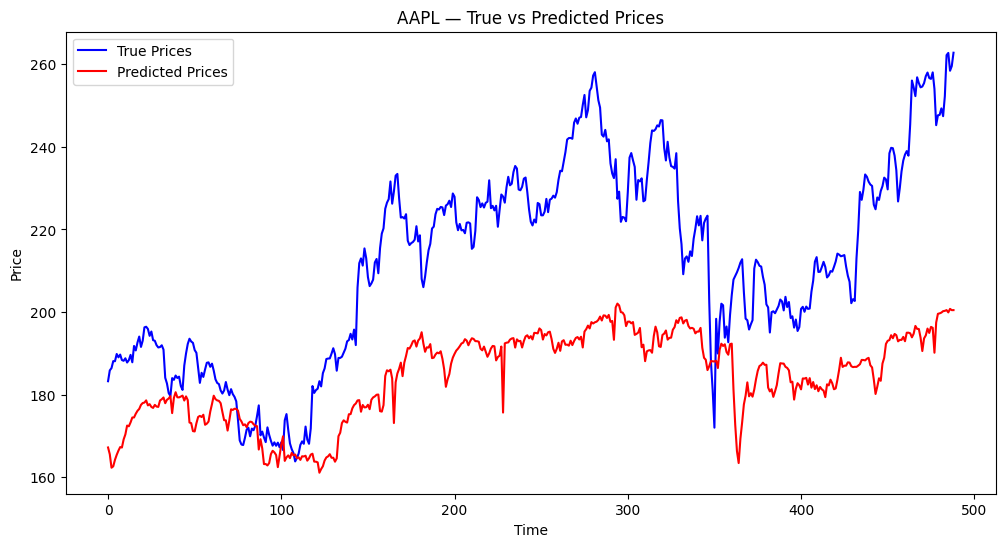

In [31]:
#matplotlib inline showing predicted vs true prices
import matplotlib.pyplot as plt
CLIP = 1600
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled[-CLIP:], label='True Prices', color='blue')
plt.plot(preds_unscaled[-CLIP:], label='Predicted Prices', color='red')
# true close price at "now" (last value of each input window, not the FORCAST target)
# plt.plot((X_test[:, -1, 0] * scale_denom + train_min)[CLIP:], label='True Prices (now)', color='green', alpha=0.25)
plt.title(f'{symbol} — True vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
symbol_other = "GOOGL"
start_date = "2015-10-26"  
end_date = "2025-10-26"

# call get_symbol (it saves the CSV but doesn't return the filename), then build filename explicitly
data = get_data(symbol_other,start_date,end_date)


print("Loaded CSV: rows:", len(data))

# change Price to Date and remove second and third rows
data = data.iloc[2:]
data = data.reset_index().rename(columns={"Price": "Date"})
data.head()

CSV exists, skipping download: GOOGL_2015-10-26_to_2025-10-26.csv
Loaded CSV: rows: 2517


C:\Users\Lau\AppData\Local\Temp\ipykernel_14860\2584634521.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(filename, index_col=0, parse_dates=True)


,Date,Close,High,Low,Open,Volume
0,2015-10-26,36.30559539794922,36.49578525151523,35.754396780485045,35.754396780485045,48776000
1,2015-10-27,36.390010833740234,36.545936881007904,35.95898557928431,36.07965143455741,38778000
2,2015-10-28,36.59361267089844,36.615957640980405,36.114415732814784,36.39895608174765,39604000
3,2015-10-29,36.98739242553711,37.083728105229405,36.50621032934241,36.57920843679526,36520000
4,2015-10-30,36.61695098876953,37.059895135111354,36.574246257017116,37.02265351755225,39984000


In [33]:
# predict  price using the loaded model + head
# (uses existing variables: model, head, device, SEQ_LEN, FORCAST, scale, train_min, scale_denom)

series_nvda = data[FEATURES].dropna().values.astype(np.float32)

print(series_nvda)

n_total = len(series_nvda)

train_min, train_max, scale_denom = get_denom(n_total, series_nvda)


series_nvda_scaled = scale(series_nvda, train_min, scale_denom)

print("series scaled shape:", series_nvda_scaled.shape)  # (n_total, 1)
# create sequences for  (reuse create_sequences from notebook)
X_nvda, y_nvda = create_sequences(series_nvda_scaled, SEQ_LEN, FORCAST)
y_nvda = y_nvda[:, 0:1]
print("X y shape:", X_nvda.shape, y_nvda.shape)  # (N, SEQ_LEN, 1)
if len(X_nvda) == 0:
    raise RuntimeError("Not enough NVDA data to build a sequence with the configured SEQ_LEN/FORCAST.")







[[3.6305595e+01 4.8776000e+07]
 [3.6390011e+01 3.8778000e+07]
 [3.6593613e+01 3.9604000e+07]
 ...
 [2.5169000e+02 3.5029400e+07]
 [2.5308000e+02 1.9901400e+07]
 [2.5992001e+02 2.8655100e+07]]
series scaled shape: (2515, 2)
X y shape: (2442, 60, 2) (2442, 1)


In [34]:

# prepare NVDA input tensor and run batch inference
X_nvda_tensor = torch.from_numpy(X_nvda).float().to(device)  # (N, seq_len, 1)

def start_infer(tensor, model, head):
  preds_batches = []


  with torch.no_grad():
      for i in range(0, tensor.size(0), BATCH_SIZE):
          xb = tensor[i : i + BATCH_SIZE]
          out_seq, _ = model(xb)
          preds = head(out_seq[:, -1, :])        # shape (B,1)
          if i == 0:
            print(out_seq.shape, out_seq[:, -1, :].shape)

            print(preds.shape)
            print(preds[:5])
          preds_batches.append(preds.cpu()) # cpu() beause later converting to numpy
  return preds_batches
preds_batches = start_infer(X_nvda_tensor, model, head)



preds_nvda_scaled = torch.cat(preds_batches, dim=0).squeeze()   # shape matches preds_nvda_unscaled
# inverse scale to original price units
preds_nvda_unscaled = preds_nvda_scaled * scale_denom[0] + train_min[0]
y_nvda_unscaled = (y_nvda * scale_denom[0] + train_min[0]).squeeze()           # (N,)
now_prices = series_nvda.squeeze()   # last value of each input window
print("now prices shape:", now_prices.shape)
print("len of all",len(preds_nvda_scaled), len(y_nvda_unscaled), len(now_prices))




torch.Size([64, 60, 64]) torch.Size([64, 64])
torch.Size([64, 1])
tensor([[0.0170],
        [0.0191],
        [0.0207],
        [0.0157],
        [0.0144]], device='cuda:0')
now prices shape: (2515, 2)
len of all 2442 2442 2515


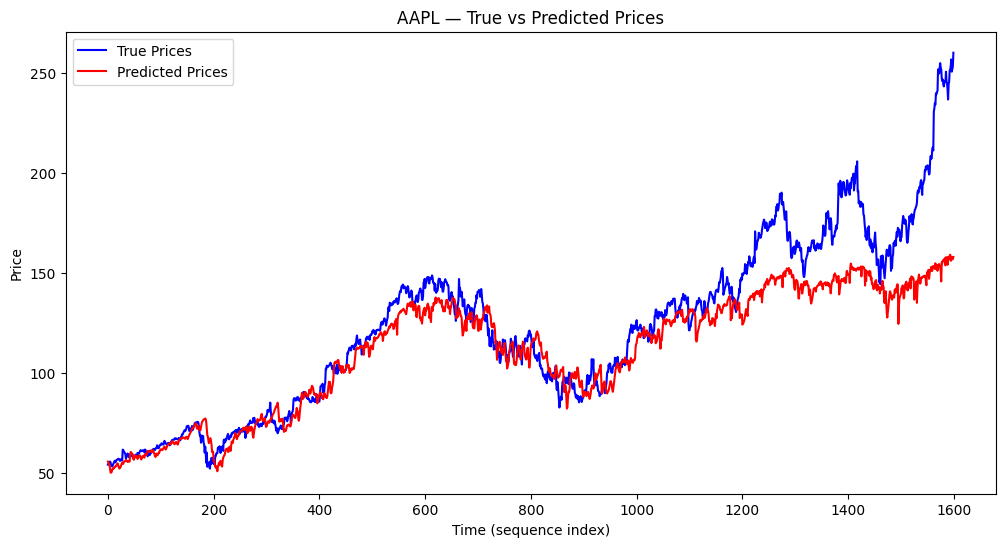

In [35]:

# plot
plt.figure(figsize=(12,6))
plt.plot(y_nvda_unscaled[-CLIP:], label='True Prices', color='blue')
plt.plot(preds_nvda_unscaled[-CLIP:], label='Predicted Prices', color='red')
# plt.plot(now_prices[-CLIP:], label='True Prices (now)', color='green', alpha=0.25)
plt.title(f'{symbol} — True vs Predicted Prices')
plt.xlabel('Time (sequence index)')
plt.ylabel('Price')
plt.legend()
plt.show()